In [3]:
import torch
from torch import nn
from datasets import load_dataset
import fastcore.all as fc
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, default_collate

In [4]:
import matplotlib.pyplot as plt

In [5]:
name = 'fashion_mnist'
x,y = 'image','label'
dsr = load_dataset(name)

Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|██████████| 2/2 [00:00<00:00, 51.53it/s]


In [8]:
def transform(b):
    b[x] = [TF.to_tensor(ele) for ele in b[x]]
    return b

In [9]:
dst = dsr.with_transform(transform)

In [10]:
def collate_dict(b):
     clt = default_collate(b)
     return (clt[x], clt[y])

class DataLoaders:
     def __init__(self, train_ds, valid_ds, batch_size, collate_fn, **kwargs):
          self.train = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, **kwargs)
          self.valid = DataLoader(valid_ds, batch_size=batch_size*2, collate_fn=collate_fn, shuffle=True, **kwargs)

In [11]:
bs = 1024
dls = DataLoaders(dst['train'], dst['test'], batch_size=bs, collate_fn=collate_dict)

In [12]:
xb,yb = next(iter(dls.train))
xb.shape, yb.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

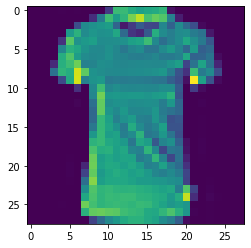

In [16]:
plt.imshow(xb[0].permute(1, 2, 0));

In [18]:
def conv(ni, nf, ks=3, s=2, act=nn.ReLU, norm=None, bias=True):
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, stride=s, padding=ks//2, bias=bias)]
    if norm is not None:
        layers.append(norm)
    if act:
        layers.append(act())
    return nn.Sequential(*layers)

def _conv_block(ni, nf, ks=3, s=2, act=nn.ReLU, norm=None, bias=True):
    return nn.Sequential(
        conv(ni, nf, ks=ks, s=1, act=act, bias=bias),
        conv(nf, nf, s=s, norm=norm, act=None, bias=bias)
    )

class ResBlock(nn.Module):
    def __init__(self, ni, nf, ks=3, s=2, act=nn.ReLU, norm=None, bias=True):
        super().__init__()
        self.conv = _conv_block(ni, nf, ks=ks, s=s, act=act, norm=norm, bias=bias)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, s=1, ks=1, act=None)
        self.pool = nn.noop if s==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()
    
    def forward(self, x):
        return self.act(self.conv(x) + self.idconv(self.pool(x)))

In [20]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.cls = self._cls()
    
    def _cls(self):
        return nn.Sequential(
            ResBlock(1, 8),
            ResBlock(8, 16),
            ResBlock(16, 32),
            ResBlock(32, 64),
            ResBlock(64, 64),
            conv(64, 10, act=False),
            nn.Flatten(),
        )
    
    def forward(self, x):
        return self.cls(x)

In [24]:
model = Classifier()
model(xb).shape

torch.Size([1024, 10])